In [14]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
import pandas as pd
import os
import utils.KEprocessing
import matplotlib.pyplot as plt

# Read full KE dataset (doesn't really work so assuming final_df is correct) 

In [182]:
"""
# Define path to the CSV file
csv_path = 'data/combined_df_noNA.csv'

# Check if the file exists
if os.path.exists(csv_path):
    # If the file exists, read the DataFrame from the CSV
    combined_df = pd.read_csv(csv_path)
else:
    # If the file does not exist, call the function to prepare the DataFrame
    combined_df = utils.KEprocessing.prepare_final_df()


# For the power dataset
long_df_path = 'data/combined_df_long.csv'
if os.path.exists(long_df_path):
    power_df = pd.read_csv(long_df_path, sep=',')
else:
    power_df = utils.KEprocessing.reshape_power_df(combined_df)
    
    
# For the weather dataset
weather_path = 'data/final_combined_weather_data.csv'
weather_df = pd.read_csv(weather_path, sep=';')    
    
# For the price dataset
filename = 'data/combined_prices_df.csv'
price_df = pd.read_csv(filename, sep=',', index_col=0)
"""

"\n# Define path to the CSV file\ncsv_path = 'data/combined_df_noNA.csv'\n\n# Check if the file exists\nif os.path.exists(csv_path):\n    # If the file exists, read the DataFrame from the CSV\n    combined_df = pd.read_csv(csv_path)\nelse:\n    # If the file does not exist, call the function to prepare the DataFrame\n    combined_df = utils.KEprocessing.prepare_final_df()\n\n\n# For the power dataset\nlong_df_path = 'data/combined_df_long.csv'\nif os.path.exists(long_df_path):\n    power_df = pd.read_csv(long_df_path, sep=',')\nelse:\n    power_df = utils.KEprocessing.reshape_power_df(combined_df)\n    \n    \n# For the weather dataset\nweather_path = 'data/final_combined_weather_data.csv'\nweather_df = pd.read_csv(weather_path, sep=';')    \n    \n# For the price dataset\nfilename = 'data/combined_prices_df.csv'\nprice_df = pd.read_csv(filename, sep=',', index_col=0)\n"

In [87]:
# For the final merged dataset
final_df_path = 'data/final_df.csv'
final_df = pd.read_csv(final_df_path, sep=',', nrows=1000000*8, usecols=['ISPRIVATEPERSON','Dew Point Temperature_P39','Power_Consumption', 'Price', 'DateTime'])
#else:
#    final_df = utils.KEprocessing.merge_weather_price(power_df, weather_df, price_df)

In [88]:
final_df['DateTime'] = pd.to_datetime(final_df['DateTime'])
final_df.set_index('DateTime', inplace=True)

In [89]:
final_df.tail(10)

,ISPRIVATEPERSON,Power_Consumption,Dew Point Temperature_P39,Price
DateTime,,,,
2021-02-22 13:00:00,Nej,0.000000,5.6,44.75
2021-02-22 13:00:00,Nej,0.015240,5.6,44.75
2021-02-22 13:00:00,Ja,0.002584,5.6,44.75
2021-02-22 13:00:00,Nej,0.000980,5.6,44.75
2021-02-22 13:00:00,Nej,0.006585,5.6,44.75
2021-02-22 13:00:00,Nej,0.000229,5.6,44.75
2021-02-22 13:00:00,Nej,0.004164,5.6,44.75
2021-02-22 13:00:00,Nej,0.001856,5.6,44.75
2021-02-22 13:00:00,Nej,0.001826,5.6,44.75


# Agregate data to get all commercial consumption (sum) in Kalmar, mean price and mean temperature per day

In [90]:
# Select only the desired columns
final_df = final_df[final_df['ISPRIVATEPERSON']=="Nej"]
final_df_subset = final_df[['Power_Consumption', 'Price', 'Dew Point Temperature_P39']]

# Resample 'Power_Consumption' (sum) and 'Price' (average)
final_df_resampled = final_df_subset.resample('D').agg({'Power_Consumption': 'sum', 'Price': 'mean', 'Dew Point Temperature_P39':'mean'})

In [91]:
final_df_resampled

,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2020-01-01,125.153777,27.040417,0.991667
2020-01-02,148.917767,27.050833,0.650000
2020-01-03,148.034055,22.752917,2.612500
2020-01-04,133.919142,21.372083,-2.400000
2020-01-05,129.457823,29.641250,-3.183333
...,...,...,...
2021-02-18,158.363375,45.189583,-2.758333
2021-02-19,156.896285,47.842917,1.154167
2021-02-20,135.274974,36.162083,1.279167


# Set value to predict

In [92]:
# Resample to every hour, taking mean of values if duplicates
y = final_df_resampled
# Fill NaNs in 'Price' column of df_prophet
y['Price'] = y['Price'].fillna(0)

# Split data into train and predict

In [116]:
y_train, y_test = temporal_train_test_split(y, test_size=45)

# Facebook prophet

## Dependency madness (doesn't work with other version of holidays in the moment)

In [ ]:
#!pip install pystan
!pip install holidays==0.24
!pip install prophet==1.1.2

## Prophet without price

In [159]:
from prophet import Prophet

forecaster = Prophet()

df_prophet = y_train.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

forecaster.fit(df_prophet)

# Finally, when making predictions, you should also provide the 'Price' values for the respective dates
df_prophet_future = y_test.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

22:41:20 - cmdstanpy - INFO - Chain [1] start processing
22:41:20 - cmdstanpy - INFO - Chain [1] done processing


,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2021-01-09,133.354421,55.980000,0.725000
2021-01-10,129.016230,43.010833,-0.387500
2021-01-11,150.100194,41.222917,1.133333
2021-01-12,150.512452,45.864583,-0.729167
2021-01-13,155.317097,42.275000,-1.891667
2021-01-14,156.842281,72.583333,-1.191667
2021-01-15,160.350518,73.917917,-9.162500
2021-01-16,140.032268,54.646667,-5.362500
2021-01-17,134.538822,52.933750,-5.525000


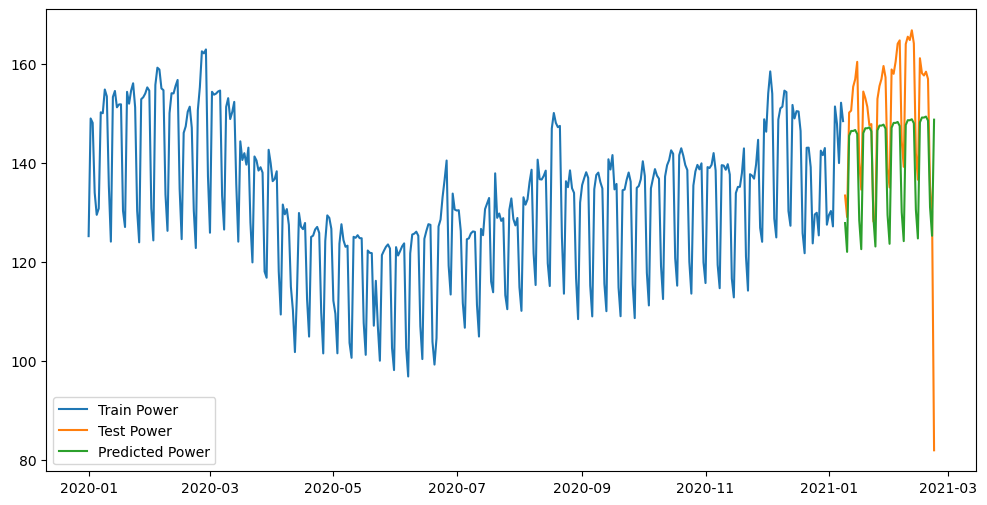

In [164]:

future_dates = y_test.reset_index()[['DateTime']]
future_dates.columns = ['ds']

y_pred = forecaster.predict(future_dates)

# Extract predictions
predictions = y_pred['yhat'][-len(y_test):]

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train.values[:, 0], label='Train Power')
plt.plot(y_test.index, y_test.values[:, 0], label='Test Power')
plt.plot(y_test.index, predictions.values, label='Predicted Power')
plt.legend(loc='best')
plt.show()


In [165]:

# Calculate predictions
predictions = y_pred['yhat']
print(len(predictions))
# Calculate actual values
actual = y_test['Power_Consumption'].values
print(len(actual))
# Calculate MAE
mae = mean_absolute_error(actual, predictions)

print(f"MAE: {mae}")

45
45
MAE: 11.115952303421606


## Prophet with price, daily and weekly seasonality

In [155]:
forecaster = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add Sweden's holidays
forecaster.add_country_holidays(country_name="SE")

# Add 'Price' as a regressor
forecaster.add_regressor('Price')
forecaster.add_regressor('Dew Point Temperature_P39')
df_prophet = y_train.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

# Fill NaNs in 'Price' column of df_prophet
df_prophet['Price'] = df_prophet['Price'].fillna(0)

print(df_prophet['Price'].isna().sum())

forecaster.fit(df_prophet)

# Finally, when making predictions, you should also provide the 'Price' values for the respective dates
df_prophet_future = y_test.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})
# Fill NaNs in 'Price' column of df_prophet
df_prophet_future['Price'] = df_prophet_future['Price'].fillna(0)
print(df_prophet_future['Price'].isna().sum())

22:40:02 - cmdstanpy - INFO - Chain [1] start processing


0


22:40:02 - cmdstanpy - INFO - Chain [1] done processing


0


In [156]:
# Create future dates and attach future 'Price' values
future_dates = y_test.reset_index()[['DateTime', 'Price','Dew Point Temperature_P39']]
future_dates.columns = ['ds', 'Price','Dew Point Temperature_P39']
future_dates['Price'] = df_prophet_future['Price']
future_dates['Price'] = future_dates['Price'].fillna(0)
future_dates['Dew Point Temperature_P39'] = df_prophet_future['Dew Point Temperature_P39']
future_dates['Dew Point Temperature_P39'] = future_dates['Dew Point Temperature_P39'].fillna(0)
y_pred = forecaster.predict(future_dates)

# Extract predictions
predictions = y_pred['yhat'][-len(y_test):]

Text(0.5, 1.0, 'Prophet with price, seasonality and temperature')

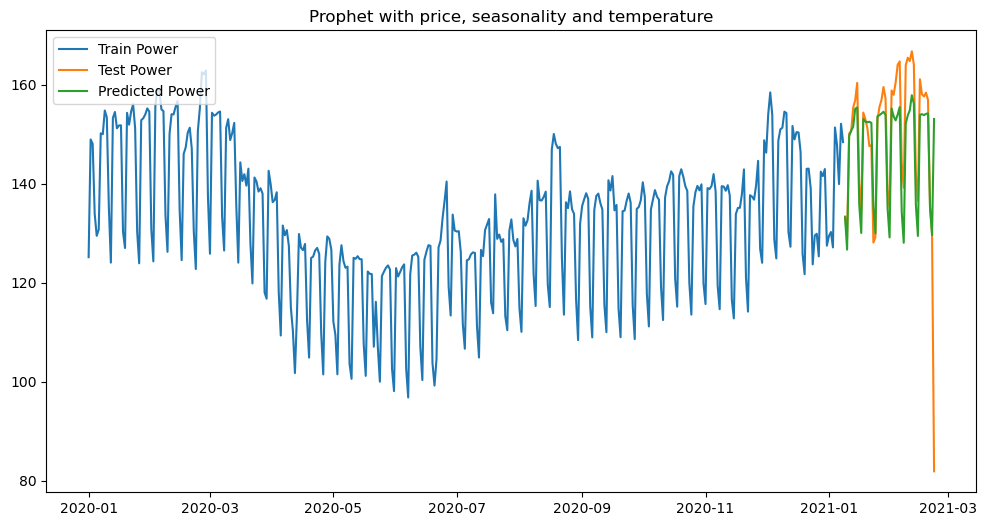

In [157]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train.values[:, 0], label='Train Power')
plt.plot(y_test.index, y_test.values[:, 0], label='Test Power')
plt.plot(y_test.index, predictions.values, label='Predicted Power')

plt.legend(loc='upper left')

# Create second y-axis for the prices

plt.title('Prophet with price, seasonality and temperature')
# Plot prices on second y-axis
#plt.twinx()
#plt.plot(y_train.index, df_prophet['Dew Point Temperature_P39'], color='r', label='Temp C')
#plt.plot(y_test.index, df_prophet_future['Dew Point Temperature_P39'], color='r', label='Temp C')

#plt.legend(loc='upper right')

#plt.show()


In [158]:

# Calculate predictions
predictions = y_pred['yhat']
print(len(predictions))
# Calculate actual values
actual = y_test['Power_Consumption'].values
print(len(actual))
# Calculate MAE
mae = mean_absolute_error(actual, predictions)

print(f"MAE: {mae}")

45
45
MAE: 6.209623036047994


## Prophet with price, seasonality and temperature

# Prophet with seasonality and temperature only 

In [120]:
forecaster = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add Sweden's holidays
forecaster.add_country_holidays(country_name="SE")
forecaster.add_regressor('Dew Point Temperature_P39')
df_prophet = y_train.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

forecaster.fit(df_prophet)
df_prophet_future = y_test.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

22:21:11 - cmdstanpy - INFO - Chain [1] start processing
22:21:12 - cmdstanpy - INFO - Chain [1] done processing


In [152]:
# Create future dates and attach future 'Price' values
future_dates = y_test.reset_index()[['DateTime', 'Dew Point Temperature_P39']]
future_dates.columns = ['ds', 'Dew Point Temperature_P39']
future_dates
future_dates['Dew Point Temperature_P39'] = df_prophet_future['Dew Point Temperature_P39']
future_dates['Dew Point Temperature_P39'] = future_dates['Dew Point Temperature_P39'].fillna(0)
y_pred = forecaster.predict(future_dates)

# Extract predictions
predictions = y_pred['yhat'][-len(y_test):]

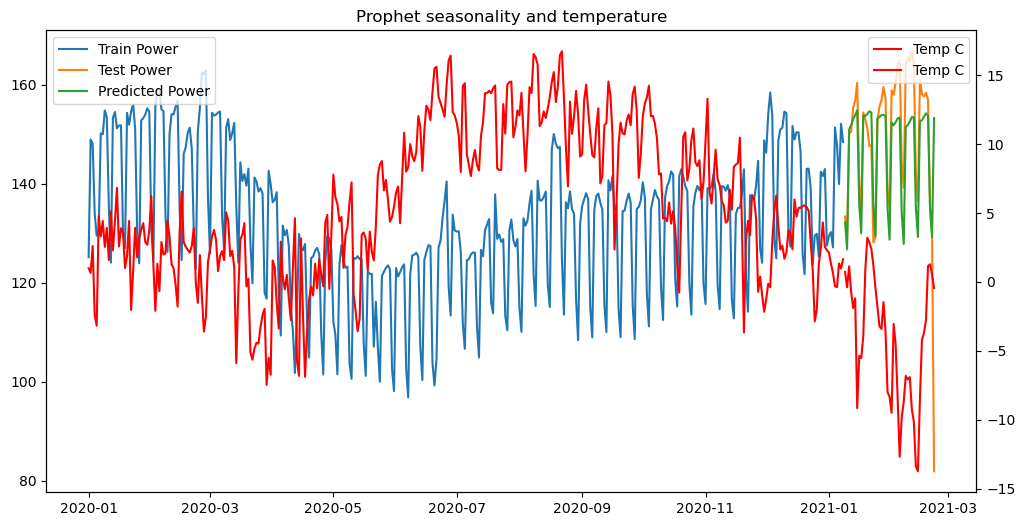

In [153]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train.values[:, 0], label='Train Power')
plt.plot(y_test.index, y_test.values[:, 0], label='Test Power')
plt.plot(y_test.index, predictions.values, label='Predicted Power')

plt.legend(loc='upper left')

# Create second y-axis for the prices

plt.title('Prophet seasonality and temperature')
# Plot prices on second y-axis
plt.twinx()
plt.plot(y_train.index, df_prophet['Dew Point Temperature_P39'], color='r', label='Temp C')
plt.plot(y_test.index, df_prophet_future['Dew Point Temperature_P39'], color='r', label='Temp C')

plt.legend(loc='upper right')

plt.show()

In [154]:
from sklearn.metrics import mean_absolute_error

# Calculate predictions
predictions = y_pred['yhat']
print(len(predictions))
# Calculate actual values
actual = y_test['Power_Consumption'].values
print(len(actual))
# Calculate MAE
mae = mean_absolute_error(actual, predictions)

print(f"MAE: {mae}")

45
45
MAE: 6.970012383743668


# SARIMA (the simplest version without parameters)

In [167]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Creating train and test set 
train = final_df_resampled.Power_Consumption[:-45]
test = final_df_resampled.Power_Consumption[-45:]

# Fit a SARIMA(0, 1, 1)(1, 1, 1, 7) model
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(1, 1, 1, 7))

# Fit the model
model_fit = model.fit(disp=False)

# Make predictions for the last 45 observations in the dataset (this should be replaced by len(test) for your case)
predictions = model_fit.predict(len(train), len(train)+len(test)-1)

# Calculate MAE
mae = mean_absolute_error(test, predictions)

print(f"MAE: {mae}")

MAE: 6.454520620626299


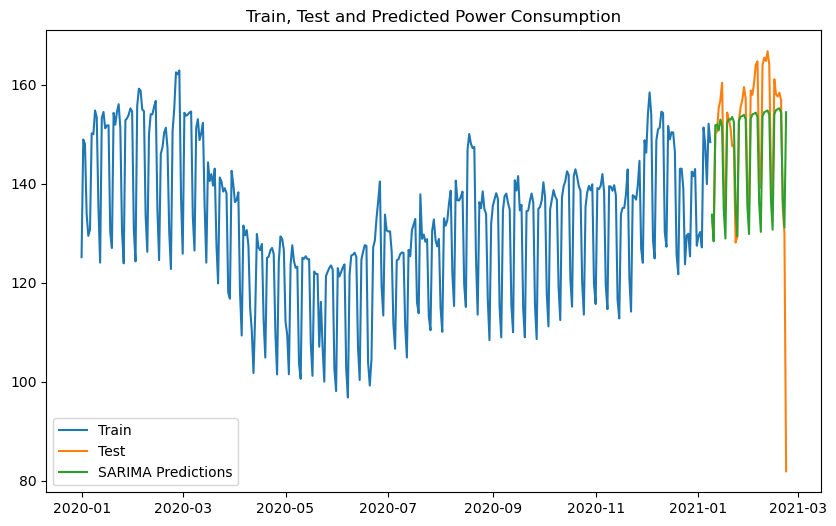

In [168]:
plt.figure(figsize=(10,6))

# Plot the training data
plt.plot(train.index, train.values, label='Train')

# Plot the testing data
plt.plot(test.index, test.values, label='Test')

# Plot the predicted data
plt.plot(test.index, predictions.values, label='SARIMA Predictions')

plt.legend(loc='best')
plt.title('Train, Test and Predicted Power Consumption')
plt.show()

# Sarimax (include temperature)

In [175]:

# Create train and test sets (using last 45 records for testing), ensuring both target and exogenous variable are included
train = final_df_resampled[:-45]
test = final_df_resampled[-45:]

# Fit a SARIMAX(0, 1, 1)x(1, 1, 1, 7) model
# Note: The last argument exog=train['Price'] adds the external variable 'Price'
model = SARIMAX(train['Power_Consumption'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 7), exog=train['Dew Point Temperature_P39'])

# Fit the model
model_fit = model.fit(disp=False)

# Make predictions, include the 'Price' as an external variable again
predictions = model_fit.predict(len(train), len(train)+len(test)-1, exog=test[['Dew Point Temperature_P39']])

# Calculate MAE
mae = mean_absolute_error(test['Power_Consumption'], predictions)

print(f"MAE: {mae}")  #when price is added gets to MAE: 7.602025616045805

MAE: 5.910306734653261


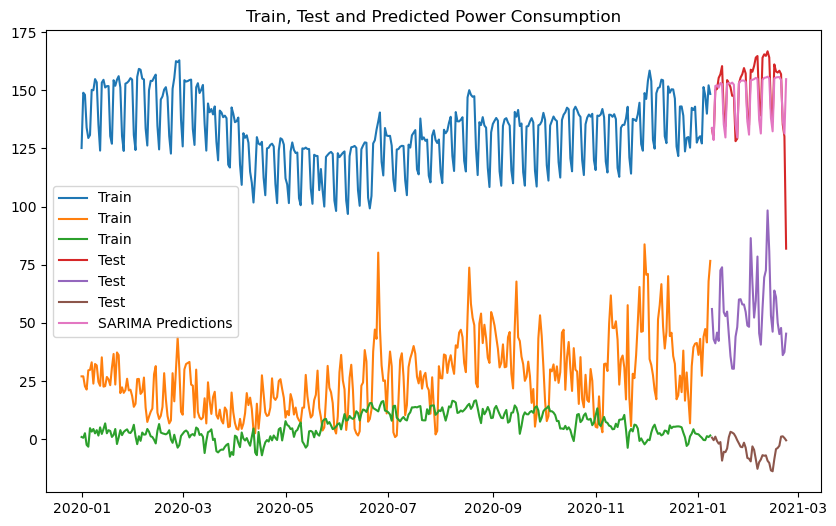

In [176]:
plt.figure(figsize=(10,6))

# Plot the training data
plt.plot(train.index, train.values, label='Train')

# Plot the testing data
plt.plot(test.index, test.values, label='Test')

# Plot the predicted data
plt.plot(test.index, predictions.values, label='SARIMA Predictions')

plt.legend(loc='best')
plt.title('Train, Test and Predicted Power Consumption')
plt.show()

# Corr matrix just to double check

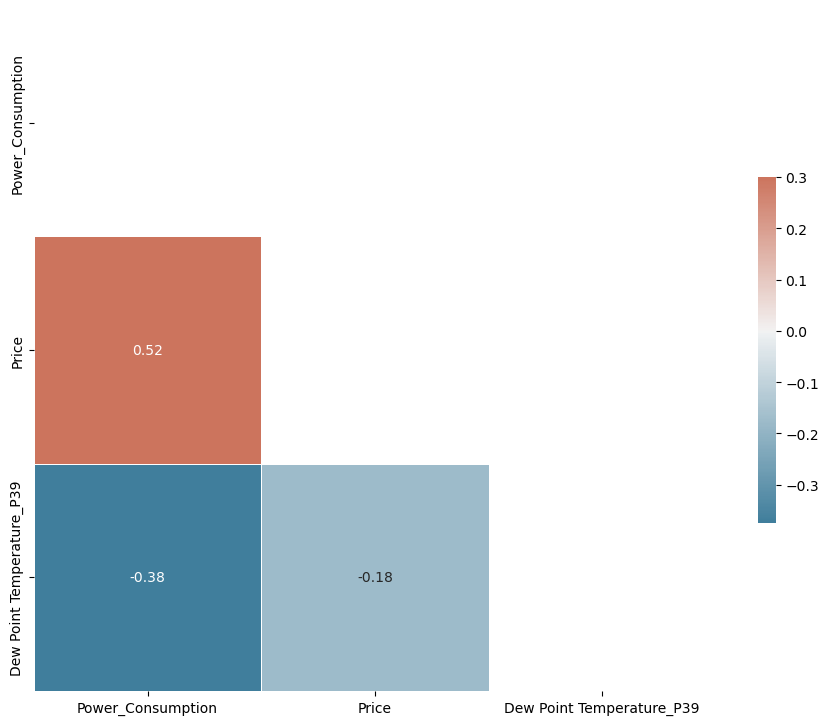

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corr = final_df_resampled[['Power_Consumption', 'Price', 'Dew Point Temperature_P39']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

# GPT commentary regarding the results

One possible explanation could be that the relationship between 'Price' and 'Power_Consumption' is nonlinear, and the models you used (Prophet, SARIMA etc.) assume a linear relationship between the forecast variable and the exogenous regressor. It's also possible that 'Price' might be correlated with 'Power_Consumption', but not actually useful in predicting it. Remember, correlation does not imply causation. Just because two variables are correlated, doesn't mean changes in one cause changes in the other. Moreover, if 'Price' has a lot of noise (random variation) that is not related to 'Power_Consumption', this could also hurt the performance of your model. Including more variables in a model will make the model more complex, which might lead to overfitting. Overfitting happens when your model performs well on training data but performs poorly on unseen data, such as validation/test dataset. Another important point is that correlation is a measure of linear relationship. It's possible that 'Power_Consumption', 'Price' and 'Dew Point Temperature_P39' have complex nonlinear interactions that a regression model is not capturing but still increases the MAE when included. The key is to understand your variables and the domain of the problem. This might also be an indication that some other form of data pre-processing, like normalization or scaling, or more complex model is needed that can capture the relationship between 'Price' and 'Power_Consumption' more accurately. Feature selection and extraction techniques could be useful, as well as trying different predictive models (nonlinear regression, decision trees, gradient boosting, neural networks etc.), which can capture non-linear relationships between variables.

# Neural network (CNN classifier)

In [184]:
from sklearn.preprocessing import MinMaxScaler

# Apply MinMax normalization
scaler = MinMaxScaler(feature_range=(0, 1))
final_df_resampled_scaled = scaler.fit_transform(final_df_resampled)

# Converting to DataFrame
final_df_resampled_scaled = pd.DataFrame(final_df_resampled_scaled, columns=final_df_resampled.columns, index=final_df_resampled.index)

In [188]:
def create_dataset(X, look_back=1):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        v = X.iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(X.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

# Define number of time steps
look_back = 10

# Split the data
train, test = final_df_resampled_scaled.Power_Consumption[:-45], final_df_resampled_scaled.Power_Consumption[-45:]

# Reshape the data
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [194]:
# Expanding dimension from (samples, time steps) to (samples, time steps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(364, 10, 1)

In [195]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)

In [196]:
from sklearn.metrics import mean_absolute_error

# Make predictions
predictions = model.predict(X_test)

# Compute MAE
mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')

2/2 [==============================] - 0s 4ms/step
MAE: 0.07397115171443917


In [197]:
import matplotlib.pyplot as plt

# if your y_test is a numpy array you can convert it back to pandas series as follows:
# y_test = pd.Series(y_test, index=test.index[look_back:])

# Print MAE and plot
print(f'MAE: {mean_absolute_error(y_test, predictions)}')

# Convert predictions to a pandas series
predictions = pd.Series(predictions.flatten(), index=y_test.index)

plt.figure(figsize=(10,6))

# Plot the training data 
plt.plot(train, label='Train')

# Plot the testing data 
plt.plot(y_test, label='Test')

# Plot the predictions
plt.plot(predictions, label='CNN Predictions')

plt.legend(loc='best')
plt.title('Train, Test and Predicted Power Consumption')
plt.show()

MAE: 0.07397115171443917


AttributeError: 'numpy.ndarray' object has no attribute 'index'